<a href="https://colab.research.google.com/github/medicharlachiranjeevi/Deep-Learning-with-Keras/blob/master/InceptionV3_full_pretrained_model_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!unzip "/content/drive/My Drive/dog-breed-identification.zip"
#!unzip train.zip 
#!unzip test.zip

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import cv2

from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from os import makedirs
from os.path import expanduser, exists, join


In [0]:
# Set the train and test folder paths.
# NOTE: train and test are now in the 'dog-breed-identification' folder since the Keras Pretrained Models data/directory is added
train_folder = 'train/'
test_folder = 'test/'

In [11]:
# get the dog image ids and labels/breed
train_dogs = pd.read_csv('labels.csv')
train_dogs.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
# Take a look at the class/breed distribution
#ax=pd.value_counts(train_dogs['breed'],ascending=True).plot(kind='barh',
#                                                       fontsize="40",
#                                                       title="Class Distribution",
#                                                       figsize=(50,100))
#ax.set(xlabel="Images per class", ylabel="Classes")
#ax.xaxis.label.set_size(40)
#ax.yaxis.label.set_size(40)
#ax.title.set_size(60)
#plt.show()

In [13]:
# Get the top 20 breeds which is what we use in this notebook
top_breeds = sorted(list(train_dogs['breed'].value_counts().head(20).index))
#train_dogs = train_dogs[train_dogs['breed']
len(set(train_dogs['breed']))

120

In [14]:
# Let's see what breeds are the top 20
print(top_breeds)
train_dogs.shape

['afghan_hound', 'airedale', 'australian_terrier', 'basenji', 'beagle', 'bernese_mountain_dog', 'blenheim_spaniel', 'cairn', 'entlebucher', 'great_pyrenees', 'irish_wolfhound', 'japanese_spaniel', 'leonberg', 'maltese_dog', 'miniature_pinscher', 'pomeranian', 'samoyed', 'scottish_deerhound', 'shih-tzu', 'tibetan_terrier']


(10222, 2)

In [0]:
# Get the labels of the top 20
target_labels = train_dogs['breed']

In [0]:
# One hot code the labels - need this for the model
one_hot = pd.get_dummies(target_labels, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [17]:
# add the actual path name of the pics to the data set
train_dogs['image_path'] = train_dogs.apply( lambda x: (train_folder + x["id"] + ".jpg" ), axis=1)
train_dogs.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [0]:
# Convert the images to arrays which is used for the model. Inception uses image sizes of 299 x 299
train_data = np.array([img_to_array(load_img(img, target_size=(299, 299))) for img in train_dogs['image_path'].values.tolist()]).astype('float32')

In [0]:
# Split the data into train and validation. The stratify parm will insure  train and validation  
# will have the same proportions of class labels as the input dataset.
x_train, x_validation, y_train, y_validation = train_test_split(train_data, target_labels, test_size=0.2, stratify=np.array(target_labels), random_state=100)

In [20]:
# Need to know how many rows in each of the train/test split so we can 
# calculate steps_per_epoch and validatoin_steps for the model.fit_generator
print ('x_train shape = ', x_train.shape)
print ('x_validation shape = ', x_validation.shape)

x_train shape =  (8177, 299, 299, 3)
x_validation shape =  (2045, 299, 299, 3)


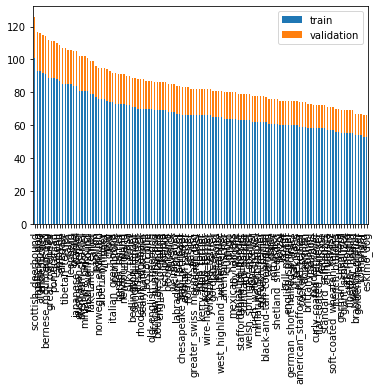

In [21]:
# Calculate the value counts for train and validation data and plot to show a good stratify
# the plot should show an equal percentage split for each class
data = y_train.value_counts().sort_index().to_frame()   # this creates the data frame with train numbers
data.columns = ['train']   # give the column a name
data['validation'] = y_validation.value_counts().sort_index().to_frame()   # add the validation numbers
new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)   # sort the data
new_plot.plot(kind='bar', stacked=True)
plt.show()

In [0]:
# Need to convert the train and validation labels into one hot encoded format
y_train = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_validation = pd.get_dummies(y_validation.reset_index(drop=True)).as_matrix()

In [0]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   # zoom_range = 0.3, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size=10, seed=10)

In [0]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_validation, y_validation, shuffle=False, batch_size=10, seed=10)

In [0]:
# Get the InceptionV3 model so we can do transfer learning
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(299, 299, 3))

In [0]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [0]:
# Add a fully-connected layer and a logistic layer with 20 classes 
#(there will be 120 classes for the final submission)
x = Dense(512, activation='relu')(x)
predictions = Dense(120, activation='softmax')(x)

In [0]:
# The model we will train
model = Model(inputs = base_model.input, outputs = predictions)

In [0]:
# first: train only the top layers i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [0]:
# Compile with Adam
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Train the model
model.fit_generator(train_generator,
                      steps_per_epoch = 175,
                      validation_data = val_generator,
                      validation_steps = 44,
                      epochs = 20,
                      verbose = 1)

Epoch 1/20
175/175 [==============================] - 85s 486ms/step - loss: 4.5880 - acc: 0.0651 - val_loss: 4.0466 - val_acc: 0.2659
Epoch 2/20
175/175 [==============================] - 80s 458ms/step - loss: 3.9891 - acc: 0.2240 - val_loss: 3.0420 - val_acc: 0.5705
Epoch 3/20
167/175 [===========================>..] - ETA: 2s - loss: 3.3164 - acc: 0.3617

In [0]:
# Use the sample submission file to set up the test data - x_test
test_data = pd.read_csv('sample_submission.csv')

In [0]:
del x_train
import gc
gc.collect()

In [0]:
# Creae the x_test
x_test = []
for i in tqdm(test_data['id'].values):
     img = cv2.imread('test/{}.jpg'.format(i))
     x_test.append(cv2.resize(img, (299, 299)))

In [0]:
# Make it an array
x_test = np.array(x_test, np.float32) / 255.

In [0]:
# Predict x_test
predictions = model.predict(x_test, verbose=2)

In [0]:
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values

In [0]:
# Create the submission data.
submission_results = pd.DataFrame(predictions, columns = col_names)

In [0]:
# Add the id as the first column
submission_results.insert(0, 'id', test_data['id'])

In [0]:
# Save the submission
submission_results.to_csv('submission.csv', index=False)